In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pickle
import spacy
from collections import Counter
from scipy.spatial.distance import cosine
from sklearn.decomposition import PCA

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

# custom imports
from LanguageTools.spacy_utils import DocumentCleaner
from LanguageTools.topic_modeling import print_topic_top_words, pca_plot_3axes
from engineer_features import assemble_corpus

font = {'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

## text preprocessing
- tokenize:

       - remove stop words
       - lemmatize
       - remove punctuation

## load tokenized lemmatized data --> corpus of documents

In [3]:
with open('pkl/data_clean_5.pkl', 'rb') as f:
    data = pickle.load(f)

corpus, corpus_tokenized = assemble_corpus(data)
data.head()

,book_author,book_name,chapter,chapter_name,extracted_text,tokens
0,J.K. Rowling,Harry Potter and the Chamber of Secrets,1,The Worst Birthday,"1. THE WORST BIRTHDAY Not for the first time,...","[worst, birthday, time, argument, break, break..."
1,J.K. Rowling,Harry Potter and the Chamber of Secrets,2,Dobbys Warning,2. DOBBY’S WARNING Harry managed not to shout...,"[dobby, warning, harry, manage, shout, close, ..."
2,J.K. Rowling,Harry Potter and the Chamber of Secrets,3,The Burrow,"3. THE BURROW “Ron,” breathed Harry, creeping...","[burrow, ron, breathe, harry, creep, window, p..."
3,J.K. Rowling,Harry Potter and the Chamber of Secrets,4,At Flourish and Blotts,4. AT FLOURISH AND BLOTTS Life at the Burrow ...,"[flourish, blotts, life, burrow, different, po..."
4,J.K. Rowling,Harry Potter and the Chamber of Secrets,5,The Whomping Willow,5. THE WHOMPING WILLOW The end of the summer ...,"[whomping, willow, end, summer, vacation, come..."


### manual filter (running out to time to fix downstream)

In [4]:
do_filter = False
if do_filter:
    rm_terms = [' ll ',' pron ',' yer ',' ve ',' don ']

    corpus_clean = []
    for doc in corpus:
        for term in rm_terms:
            doc_ = doc.replace(term, '')
        corpus_clean.append(doc_)
    corpus = corpus_clean


## create tf-idf and tf matrices

In [5]:
n_features = 1000

tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=n_features, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(corpus)
tfidf_feat_names = tfidf_vectorizer.get_feature_names()

tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=n_features, stop_words='english')
tf = tf_vectorizer.fit_transform(corpus)
tf_feat_names = tf_vectorizer.get_feature_names()

print('bag-of-words matrix dimensions: {} documents x {} words'.format(tf.shape[0], tf.shape[1]))

bag-of-words matrix dimensions: 198 documents x 1000 words


## W (doc to topics) and H (topics to words) matrices for NMF and LDA

In [6]:
# nmf W and H
n_topics = 10

nmf = NMF(n_components=n_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)
nmf_W = nmf.transform(tfidf)
nmf_H = nmf.components_
print('NMF W dimensions: {} documents x {} topics'.format(nmf_W.shape[0], nmf_W.shape[1]))
print('NMF H dimensions: {} topics x {} words'.format(nmf_H.shape[0], nmf_H.shape[1]))

# lda topics
lda = LatentDirichletAllocation(n_components=n_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)
lda_W = lda.transform(tf)
lda_H = lda.components_
print('\nLDA W dimensions: {} documents x {} topics'.format(lda_W.shape[0], lda_W.shape[1]))
print('LDA H dimensions: {} topics x {} words'.format(lda_H.shape[0], lda_H.shape[1]))

NMF W dimensions: 198 documents x 10 topics
NMF H dimensions: 10 topics x 1000 words

LDA W dimensions: 198 documents x 10 topics
LDA H dimensions: 10 topics x 1000 words


## top n words in topics determined by NMF and LDA models

In [7]:
n_top_words = 10
models = [lda, nmf]
labels = ['LDA', 'NMF']
top_words = {}
for model, label in zip(models, labels):
    print(f"\nTopics in corpus, {label} model:")
    words = print_topic_top_words(model, tfidf_feat_names, n_top_words)
    top_words[label] = words


Topics in corpus, LDA model:
topic 0: yes dark little riddle professor malfoy ron voldemort hermione wand
topic 1: boy house door room letter dursleys petunia aunt dudley uncle
topic 2: room lupin wand door malfoy dumbledore snape hagrid professor hermione
topic 3: horcrux soul sword hermione greyback tom diary ron voldemort dumbledore
topic 4: hope magic moment man wand dumbledore voldemort scrimgeour fudge prime
topic 5: winky elf dumbledore room moody snape potter sir hermione dobby
topic 6: vernon voldemort snape dumbledore dudley room dark uncle ron hermione
topic 7: wizard door dark professor voldemort wand snape ron sirius hermione
topic 8: wand hogwarts wizard door george dumbledore fred hagrid hermione weasley
topic 9: student hall goblet maxime champion professor madame karkaroff hermione dumbledore


Topics in corpus, NMF model:
topic 0: ginny fred mcgonagall room door neville umbridge malfoy professor hermione
topic 1: man yes slughorn tom albus kreacher fudge sirius volde

## Which topics are the most distinct? 
    - these topics are kind of gobbledy-gook, it would be nice to narrow the selection down to the topics that are most distict
    - topics are rows of the H matrix
    - assess pairwise cosine distance
### reduce dimensionality
    - computing distance metrics on the H matrix suffers from the curse of dimensionality: distances in 1000 dimensions become intractably large and comparisons are distorted
    - use PCA to reduce the dimensionality of the topic-to-word matrix
        - choose number of components
    - compare cosine distance on this reduced matrix
    - find the topics that are most unique

In [8]:
def cosine_distance_matrix(X, axis=1):
    '''
    param
    -----
    X numpy array
    axis int
    '''
    if axis==0:
        X = X.T
    n = X.shape[0]
    arr = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            dist = cosine(X[i,:],X[j,:])
            arr[i,j] = dist
    return arr

### choose number of components

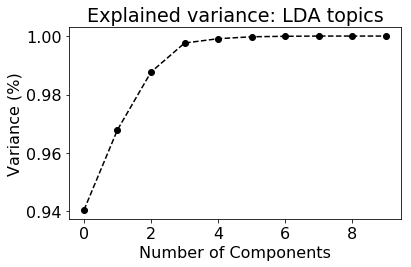

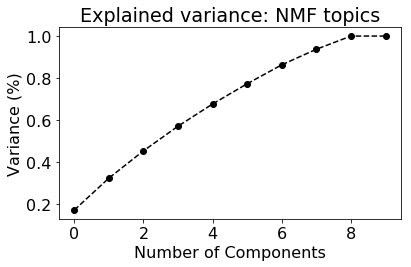

In [9]:
font = {'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

arrs = [lda_H, nmf_H]
labels = ['LDA', 'NMF']
for arr, label in zip(arrs, labels):
    # fit PCA
    pca = PCA(n_components=10)
    pca.fit(arr)
    # plot cumulative explained variance
    fig = plt.figure()
    plt.plot(np.cumsum(pca.explained_variance_ratio_),'--o',color='k')
    plt.title(f'Explained variance: {label} topics')
    plt.xlabel('Number of Components')
    plt.ylabel('Variance (%)')
    plt.tight_layout()
    #plt.savefig(f'figures/pca_{label}_kw30.png',dpi=300)
    

### n components chosen by inspecting cumulative explained variance curves
    - LDA: 3 components
    - NMF: 8 components

### visually inspect components in reduced dimensions
__LDA:__

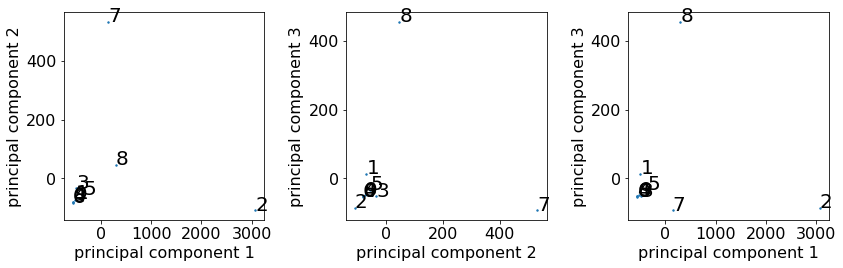

In [10]:
pca = PCA(n_components=3)
topics_pca = pca.fit_transform(lda_H)

pca_plot_3axes(topics_pca, savefig=False, filename='figures/pca_topics_lda_kw30.png')

__NMF__:
 - there are 28 combinations of 8 choose 2
 - just plot the first several
 - assess quantitatively

In [11]:
# number of combinations
def nCr(n,r):
    from math import factorial
    return int((factorial(n)/ (factorial(r) * factorial(n-r))))
            
print(f'{nCr(8,2)} combinations')

28 combinations


__get combinations with lowest 3 components__

In [12]:
from itertools import combinations
cc = combinations(range(8),2)
cc_low3 = [x for x in cc if x[0] <= 3 and x[1] <= 3]

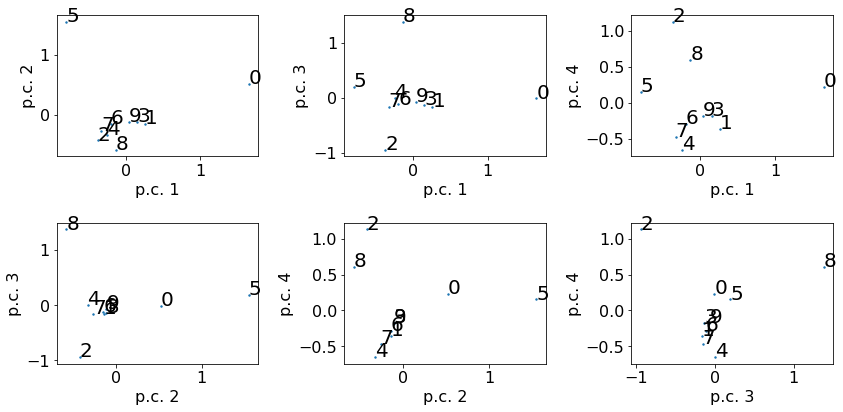

In [13]:
pca = PCA(n_components=8)
topics_pca = pca.fit_transform(nmf_H)

# pca plot
fig, axs_ = plt.subplots(2,3, figsize=(12,6))
axs = axs_.flatten()
ax_ii = cc_low3
for ax, ii in zip(axs, ax_ii):
    xx = topics_pca[:,ii[0]]
    yy = topics_pca[:,ii[1]]
    labels = range(len(xx))

    ax.scatter(xx, yy, s=2)
    for i, x in enumerate(labels):
        ax.text(xx[i], yy[i], x, size=20)

    ax.set_xlabel(f'p.c. {ii[0]+1}')
    ax.set_ylabel(f'p.c. {ii[1]+1}')

plt.tight_layout()
#plt.savefig('figures/pca_topics_nmf_kw30.png', dpi=300)


### Unique topics identified by PCA
    - visually:
        - LDA: [8,7,2,5,others]
        - NMF: [8,0,5,2,others] (hard to tell graphically, 8 components)
    - computed with cosine distance, ranked descending (computed below):
        - LDA: [2 8 7 5 6 9 0 4 1 3]
        - NMF: [5 0 8 2 3 4 7 6 1 9]
    - sanity check: the top 3-4 computed topics are also graphically most unique (per method)

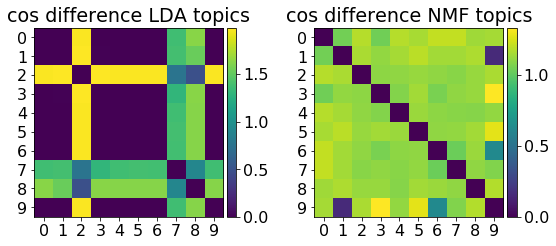

In [14]:
arrs = [lda_H, nmf_H]
labels = ['LDA', 'NMF']
nn = [3, 8]
clims = [(0,2),(0.5,1.5)]
n_topics = 10
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, axs = plt.subplots(1,2, figsize=(8,4))

unique_topics_sorted = {}
for arr, label, n, ax, clim in zip(arrs, labels, nn, axs, clims):

    pca = PCA(n_components=n)
    topics_pca = pca.fit_transform(arr)
    arr_dist = cosine_distance_matrix(topics_pca)
    
    # calc most different topics
    sum_difference = np.sum(arr_dist, axis=1)
    unique_topics = np.argsort(sum_difference)
    unique_topics_sorted[label] = np.flipud(unique_topics) # arr is ascending
    
    # plot 
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    im = ax.imshow(arr_dist)
    ax.set_title(f'cos difference {label} topics')
    ax.set_xticks(range(n_topics));
    ax.set_yticks(range(n_topics));
    cbar = fig.colorbar(im, cax=cax, orientation='vertical')
    
plt.tight_layout()
#plt.savefig('figures/pca_cos_distance_kw30.png', dpi=300)

In [15]:
print('topics ranked by uniqueness:')
for k,v in unique_topics_sorted.items():
    print(f'{k}: {v}')


topics ranked by uniqueness:
LDA: [2 8 7 5 6 9 0 4 1 3]
NMF: [5 0 8 2 3 4 7 6 1 9]


## look at the most unique topics: top 4 + 10 most common terms in other 6

In [16]:
top_n = 4
others = []
for label in labels:
    print(f'{label} top {top_n} topics:')
    ww = top_words[label]
    # print top 4 topics
    ii_top = unique_topics_sorted[label][:top_n]
    [print(f'{i}: {ww[i]}') for i in ii_top]
    # print 'average' of other topics
    print(f'\n{label} most common words in other topics:')
    ii_other = list(set(unique_topics_sorted[label]) ^ set(ii_top))
    other_l = [ww[i] for i in ii_other]
    other = [x for sub in other_l for x in sub]
    others.append(other)
    c = Counter(other).most_common(10)
    other_10 = [x[0] for x in c]
    print(other_10)

    print()

LDA top 4 topics:
2: ['room', 'lupin', 'wand', 'door', 'malfoy', 'dumbledore', 'snape', 'hagrid', 'professor', 'hermione']
8: ['wand', 'hogwarts', 'wizard', 'door', 'george', 'dumbledore', 'fred', 'hagrid', 'hermione', 'weasley']
7: ['wizard', 'door', 'dark', 'professor', 'voldemort', 'wand', 'snape', 'ron', 'sirius', 'hermione']
5: ['winky', 'elf', 'dumbledore', 'room', 'moody', 'snape', 'potter', 'sir', 'hermione', 'dobby']

LDA most common words in other topics:
['voldemort', 'hermione', 'dumbledore', 'ron', 'dark', 'professor', 'wand', 'room', 'dudley', 'uncle']

NMF top 4 topics:
5: ['buckbeak', 'quirrell', 'cabin', 'pron', 'forest', 'giant', 'don', 'dragon', 'yeh', 'fang']
0: ['ginny', 'fred', 'mcgonagall', 'room', 'door', 'neville', 'umbridge', 'malfoy', 'professor', 'hermione']
8: ['filch', 'dark', 'potion', 'professor', 'malfoy', 'severus', 'lord', 'lily', 'potter', 'sirius']
2: ['birthday', 'owl', 'car', 'letter', 'dursley', 'dursleys', 'aunt', 'petunia', 'uncle', 'dudley']



## subjective analysis of algorithmically selected topics
    - up to the this point the entire language processing workflow has been automated
    - at this point I'm going to try to make sense of the selected topics
   
    

## Final topic selection

__Topics in corpus, LDA model (bold = algorithmically determined to be unique):__
- topic 0: yes dark little riddle professor malfoy ron voldemort hermione wand
- topic 1: boy house door room letter dursleys petunia aunt dudley uncle
- __topic 2: room lupin wand door malfoy dumbledore snape hagrid professor hermione__
- topic 3: horcrux soul sword hermione greyback tom diary ron voldemort dumbledore
- topic 4: hope magic moment man wand dumbledore voldemort scrimgeour fudge prime
- __topic 5: winky elf dumbledore room moody snape potter sir hermione dobby__
- topic 6: vernon voldemort snape dumbledore dudley room dark uncle ron hermione
- __topic 7: wizard door dark professor voldemort wand snape ron sirius hermione__
- __topic 8: wand hogwarts wizard door george dumbledore fred hagrid hermione weasley__
- topic 9: student hall goblet maxime champion professor madame karkaroff hermione dumbledore

__Topics in corpus, NMF model:__
- __topic 0: ginny fred mcgonagall room door neville umbridge malfoy professor hermione__
- topic 1: man yes slughorn tom albus kreacher fudge sirius voldemort riddle
- __topic 2: birthday owl car letter dursley dursleys aunt petunia uncle dudley__
- topic 3: wizard kitchen charlie ron arthur ginny percy sirius george fred
- topic 4: tonk werewolf james professor crookshanks dementors scabbers sirius black pettigrew
- __topic 5: buckbeak quirrell cabin pron forest giant don dragon yeh fang__
- topic 6: task winky madame maxime krum crouch champion karkaroff cedric bagman
- topic 7: master diary parvati lockhart krum bludger potter elf winky sir
- __topic 8: filch dark potion professor malfoy severus lord lily potter sirius__
- topic 9: light eater body snake lord bellatrix eaters death wormtail wand

The algorithmic selection of most unique topics is alright. Some are useful, some less so. For this dataset, it's curious that the NMF model only found 6 distinct topics; 7-9 are indentical (and useless). I think it's reasonable that at this level in the project it's OK for a human to review the automatically-generated options. It's interesting to note that the NMF and LDA algorithms are very sensitive to small changes to the data. For example, these topics were discovered by a prior run, without a few erroneous words removed (e.g. 'yeh', 'pron'):


__interesting topics from prior run:__
- NMF topic 2b: bark muggles parent holiday owl hedwig bedroom dursleys drive uncle (muggles and london)

### My top topics:
- LDA topic 7: wizard door dark professor voldemort wand snape ron sirius hermione (central theme)
- LDA topic 3: horcrux soul sword hermione greyback tom diary ron voldemort dumbledore (almost a specific chapter)
- NMF topic 9: light eater body snake lord bellatrix eaters death wormtail wand    (dark theme, slytherin things)
- NMF topic 8: filch dark potion professor malfoy severus lord lily potter sirius (dark, Harry's parents, Sirius)
- LDA topic 8: wand hogwarts wizard door george dumbledore fred hagrid hermione weasley (central theme, light)
- NMF topic 5: buckbeak quirrell cabin pron forest giant don dragon yeh fang       (animals, forest)
- NMF topic 2: birthday owl car letter dursley dursleys aunt petunia uncle dudley  (home front)

